### 전이 학습

In [30]:
import warnings
warnings.filterwarnings(action='ignore')

import os 
import random
import sys
import time
from time import localtime, strftime
 
import numpy as np
import tensorflow as tf
  
# import cv2
  
import matplotlib
import matplotlib.pyplot as plt
 
from matplotlib import font_manager, rc
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical
 
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
 
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
  
from sklearn.preprocessing import LabelEncoder  # class가 문자열인경우 변환
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋을 나눔
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증
 
 
 
# 기본 제공 데이터 
from keras.datasets import mnist
from keras.datasets import cifar10
 
# -----------------------------------------------------------------------------------------
# CNN 테스트시 failed to create cublas handle: CUBLAS_STATUS_ALLOC_FAILED 에러 발생시 추가
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 1.0 # 메모리를 사전에 모두 할당
config.gpu_options.allow_growth = True                     # 메모리를 필요시 할당
session = tf.Session(config=config)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) # 연결된 device 확인
# -----------------------------------------------------------------------------------------
 
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
# windows 10
# font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgunsl.ttf").get_name()
rc('font', family=font_name)           # 맑은 고딕 폰트 지정
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정
 
# Jupyter에게 matplotlib 그래프를 출력 영역에 표시할 것을 지시하는 명령
%matplotlib inline  
 
LOG_DIR = '../../logs' # 폴더명만 지정하면 자동으로 생성됨.
 
# tensorboard --logdir=C:/ai_201904/ws_python/notebook/logs 
# graph = tf.get_default_graph()
# with tf.summary.FileWriter(LOG_DIR) as writer:
#     writer.add_graph(graph)
 

In [31]:
from tensorflow.python.keras.applications.vgg16 import VGG16


# 기존의 1000 클래스의 출력을 사용하지 않기 때문에
# include_top=False로 출력층을 포함하지 않는 상태로 불러들임
vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))

# 모델의 요약 확인. 출력층이 포함되지 않은 것을 알 수 있다.
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [32]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten


# 모델을 편집해서 네트워크를 생성할 함수 정의
def build_transfer_model(vgg16):
    # 호출한 모델을 사용해서 새로운 모델 작성
    model = Sequential(vgg16.layers)

    # 호출한 가중치의 일부는 재학습하지 않도록 설정
    # 여기서는 추가한 층과 출력층에 가까운 층의 가중치만 재학습
    for layer in model.layers[:15]:
        layer.trainable = False

    # 추가할 출력 부분의 층을 구축
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# 정의한 함수를 호출해서 네트워크를 생성
model = build_transfer_model(vgg16)

In [33]:
# 전이 학습 모델의 추가
from tensorflow.python.keras.optimizers import SGD


model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=0.0001, momentum=0.9),
    metrics=['accuracy']
)

In [34]:
# 모델 요약 확인
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

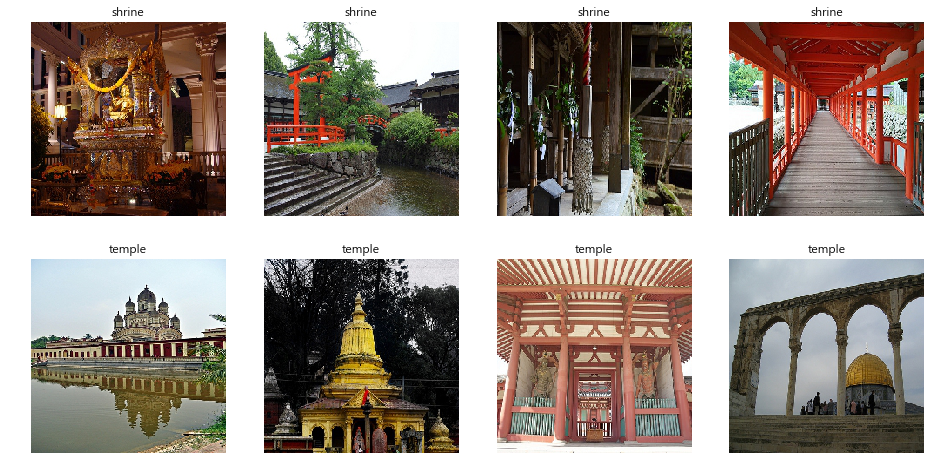

In [35]:
# 사원, 절 / 신사의 확인
from utils import show_train_samples


# 학습용 데이터의 내용을 랜덤으로 표시
img_dir = 'images/shrine_temple'
show_train_samples(img_dir, classes=('shrine', 'temple'), seed=1)

In [36]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.vgg16 import preprocess_input


# 학습용 이미지를 읽어 들이기 위한 생성기 생성. 스케일 변환과 데이터 확장의 인수를 지정
idg_train = ImageDataGenerator(
    rescale=1/255.,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

In [37]:
# 이미지를 읽어 들이기 위한 iterator 생성

# 훈련용 데이터(학습할 때 이용)
img_itr_train = idg_train.flow_from_directory(
    'images/shrine_temple/train', 
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

# 검증용 데이터(학습할 때 이용)
img_itr_validation = idg_train.flow_from_directory(
    'images/shrine_temple/validation', 
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [38]:
# 모델 저장용 폴더 생성

import os
from datetime import datetime


# 모델 저장용 폴더 준비
model_dir = os.path.join(
    'models', 
    datetime.now().strftime('%y%m%d_%H%M') # 190602_2330
)
os.makedirs(model_dir, exist_ok=True) # 상위경로도 모두 생성
print('model_dir:', model_dir)  # 저장할 폴더 이름 표시

dir_weights = os.path.join(model_dir, 'weights')
os.makedirs(dir_weights, exist_ok=True)

model_dir: models\190603_0001


In [39]:
# 네트워크 구조와 클래스 레이블의 저장
import json
import pickle


# 네트워크 저장
model_json = os.path.join(model_dir, 'model.json')
with open(model_json, 'w') as f:
    json.dump(model.to_json(), f)

# 학습할 때의 정답 레이블 저장
model_classes = os.path.join(model_dir, 'classes.pkl')
with open(model_classes, 'wb') as f:
    pickle.dump(img_itr_train.class_indices, f)

In [40]:
import math

# 미니 배치를 몇 개 학습하면 1에폭이 되는지 계산(학습할 때 지정할 필요가 있다)
batch_size = 16
steps_per_epoch = math.ceil(
    img_itr_train.samples/batch_size
)
validation_steps = math.ceil(
    img_itr_validation.samples/batch_size
)

In [41]:
# 콜백을 생성하고 설정
from tensorflow.python.keras.callbacks import ModelCheckpoint, CSVLogger


# 콜백의 설정
cp_filepath =  os.path.join(dir_weights, 'ep_{epoch:02d}_ls_{loss:.1f}.h5')
cp = ModelCheckpoint(
                     cp_filepath, 
                     monitor='loss', 
                     verbose=0,
                     save_best_only=False, 
                     save_weights_only=True, 
                     mode='auto', 
                     period=5
                     )

csv_filepath =  os.path.join(model_dir, 'loss.csv')
csv = CSVLogger(csv_filepath, append=True)

In [42]:
# GPU 학습 권장
n_epoch = 5

# 모델 학습
hist = model.fit_generator(
    img_itr_train, 
    steps_per_epoch=steps_per_epoch, 
    epochs=n_epoch,  # 학습할 에폭수
    validation_data=img_itr_validation, 
    validation_steps=validation_steps,
    callbacks = [cp, csv]
)

Epoch 1/5
38/38 [==============================]38/38 [==============================] - 9s 235ms/step - loss: 0.6586 - acc: 0.6200 - val_loss: 0.4383 - val_acc: 0.8700

Epoch 2/5
38/38 [==============================]38/38 [==============================] - 7s 190ms/step - loss: 0.4327 - acc: 0.8109 - val_loss: 0.3947 - val_acc: 0.8200

Epoch 3/5
38/38 [==============================]38/38 [==============================] - 7s 192ms/step - loss: 0.3598 - acc: 0.8570 - val_loss: 0.2539 - val_acc: 0.9250

Epoch 4/5
38/38 [==============================]38/38 [==============================] - 8s 199ms/step - loss: 0.3321 - acc: 0.8438 - val_loss: 0.2432 - val_acc: 0.9150

Epoch 5/5
38/38 [==============================]38/38 [==============================] - 10s 271ms/step - loss: 0.2959 - acc: 0.8684 - val_loss: 0.2238 - val_acc: 0.9200



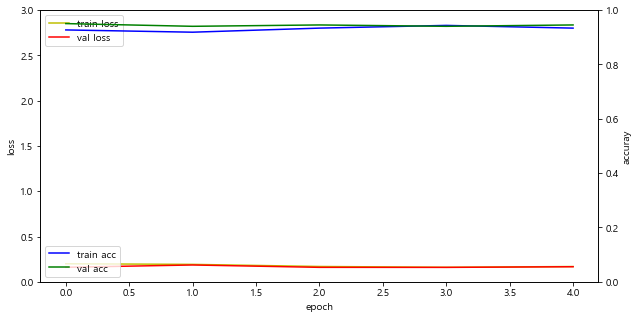

In [26]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)      # 챠트 크기 설정
 
acc_ax = loss_ax.twinx()
 
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 3.0])
 
acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])
 
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')
 
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
 
plt.show()

In [27]:
# 학습한 모델을 사용해서 예측
from utils import load_random_imgs

# 학습 결과를 산출(추론)
test_data_dir = 'images/shrine_temple/test/unknown'
x_test, true_labels = load_random_imgs(
    test_data_dir, 
    seed=1
)
x_test_preproc= preprocess_input(x_test.copy())/255.
probs = model.predict(x_test_preproc)

probs

array([[0.02147139],
       [0.46254966],
       [0.27970427],
       [0.5198057 ],
       [0.11684769],
       [0.98272336],
       [0.01431505],
       [0.9999101 ]], dtype=float32)

In [28]:
# 클레스 레이플 확인
print('class_indices:', img_itr_train.class_indices)

class_indices: {'temple': 1, 'shrine': 0}


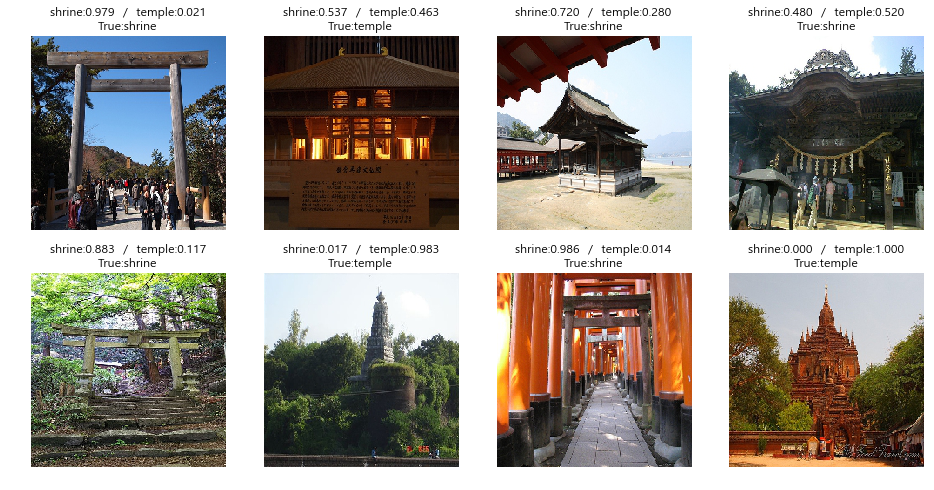

In [29]:
# 결과를 평가
from utils import show_test_samples


# 평가용이미지 표시
show_test_samples(
    x_test, probs, 
    img_itr_train.class_indices, 
    true_labels
)